<a href="https://colab.research.google.com/github/SumitMohan/Covid-19-Third-Wave-Prediction/blob/main/Daily_Active_cases_Prediction_using_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

*   Python
*   Pandas
*   Statistics
*   NumPy
*   Matplotlib
*   Keras
*   Scikit-Learn


## Objectives


## Required libraries Importing


Some libraries should be imported .


In [1]:
import pandas as pd
import numpy as np


In [2]:
covid_word = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
covid_word

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163554,ZWE,Africa,Zimbabwe,2022-02-17,232598.0,385.0,222.571,5381.0,2.0,1.143,15411.832,25.510,14.747,356.542,0.133,0.076,1.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3314.0,0.220,0.0672,14.9,tests performed,7795362.0,4331082.0,3362638.0,101642.0,12401.0,8448.0,51.65,28.70,22.28,0.67,560.0,2978.0,0.020,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
163555,ZWE,Africa,Zimbabwe,2022-02-18,233030.0,432.0,259.429,5385.0,4.0,1.571,15440.456,28.624,17.190,356.808,0.265,0.104,1.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2043572.0,135.406,NaN,3439.0,0.228,0.0754,13.3,tests performed,7810556.0,4336161.0,3367921.0,106474.0,15194.0,9263.0,51.75

Let's study our DataSet. As you can see, it consist of 159321 rows × 67 columns. There is some missing data are observed in the DataSet. We should be sure that Python recognized types of data correctly.


In [3]:
covid_word.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163559 entries, 0 to 163558
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    163559 non-null  object 
 1   continent                                   153759 non-null  object 
 2   location                                    163559 non-null  object 
 3   date                                        163559 non-null  object 
 4   total_cases                                 160554 non-null  float64
 5   new_cases                                   160513 non-null  float64
 6   new_cases_smoothed                          159362 non-null  float64
 7   total_deaths                                142822 non-null  float64
 8   new_deaths                                  143003 non-null  float64
 9   new_deaths_smoothed                         142873 non-null  float64
 

As you can see, 66 columns of COVID-19 data were recognized correctly (float64). First 4 columns and tests_units were recognized as objects. Let's investigate them:


In [4]:
fields = ['iso_code', 'continent', 'location', 'tests_units']
covid_word[fields]

,iso_code,continent,location,tests_units
0,AFG,Asia,Afghanistan,NaN
1,AFG,Asia,Afghanistan,NaN
2,AFG,Asia,Afghanistan,NaN
3,AFG,Asia,Afghanistan,NaN
4,AFG,Asia,Afghanistan,NaN
...,...,...,...,...
163554,ZWE,Africa,Zimbabwe,tests performed
163555,ZWE,Africa,Zimbabwe,tests performed
163556,ZWE,Africa,Zimbabwe,tests performed
163557,ZWE,Africa,Zimbabwe,tests performed


Let's show information about the field date.


In [5]:
covid_word['date']

0         2020-02-24
1         2020-02-25
2         2020-02-26
3         2020-02-27
4         2020-02-28
             ...    
163554    2022-02-17
163555    2022-02-18
163556    2022-02-19
163557    2022-02-20
163558    2022-02-21
Name: date, Length: 163559, dtype: object

### Сhange the data types of columns


As you can see, the columns: 'iso_code', 'continent', 'location', 'tests_units' have many repetitions and should be assigned to categorical fields **pandas.astype()**. 

The field 'data' should be converted into DataTime type **pandas.to_datetime**  
To see the results we can use **pandas.describe()**.


In [6]:
fields = ['iso_code', 'continent', 'location', 'tests_units']
covid_word[fields] =covid_word[fields].astype('category')
covid_word.loc[:, 'date'] = pd.to_datetime(covid_word['date'])
covid_word[fields].describe()

,iso_code,continent,location,tests_units
count,163559,153759,163559,85217
unique,238,6,238,4
top,ARG,Africa,Argentina,tests performed
freq,783,38757,783,62494


### Rows filtering


As we can see, the DataSet contains information about 6 continents and 238 countries.
The field 'tests_units' consist of 4 categories. To show a list of countries, we can use **pandas.Series.cat.categories**.


In [7]:
covid_word['location'].cat.categories

Index(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       ...
       'Uzbekistan', 'Vanuatu', 'Vatican', 'Venezuela', 'Vietnam',
       'Wallis and Futuna', 'World', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', length=238)

Let's investigate the dynamics of new cases of COVID-19 for a separate country. We will use India for saving models and further forecast. You can use your country. Let's use a pandas filter to do this.


In [8]:
covid_word.index = covid_word['date']
c_covid = covid_word[covid_word['location'] == "India"]
c_covid

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-30,IND,Asia,India,2020-01-30,1.0,1.0,NaN,NaN,NaN,NaN,0.001,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.393409e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,NaN,NaN,NaN,NaN
2020-01-31,IND,Asia,India,2020-01-31,1.0,0.0,NaN,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.393409e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,NaN,NaN,NaN,NaN
2020-02-01,IND,Asia,India,2020-02-01,1.0,0.0,NaN,NaN,NaN,NaN,0.001,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.393409e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,NaN,NaN,NaN,NaN
2020-02-02,IND,Asia,India,2020-02-02,2.0,1.0,NaN,NaN,NaN,NaN,0.001,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.393409e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,NaN,NaN,NaN,NaN
2020-02-03,IND,Asia,India,2020-02-03,3.0,1.0,NaN,NaN,NaN,NaN,0.002,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.19,1.393409e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,IND,Asia,India,2022-02-17,42780235.0,25920.0,34871.143,510905.0,492.0,532.571,30701.850,18.602,25.026,366.658,0.353,0.382,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1247481.0,755532460.0,542.219,0.895,1333770.0,0.957,0.0261,38.2,samples tested,1.743932e+09,961022242.0,765507484.0,17402240.0,5281682.0,4790451.0,125.16,68.97,54.94,1.25,3438.0,958368.0,0.069,NaN,1.393409e+09,450.419,28.2,5.989,3.414,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.645,NaN,NaN,NaN,NaN
2022-02-18,IND,Asia,India,2022-02-18,42802505.0,22270.0,30851.571,511230.0,325.0,464.143,30717.832,15.982,22.141,3

Let's choose the fields 'new_cases', 'new_cases_smoothed' for forecasting. First of all, we should visualize this data.


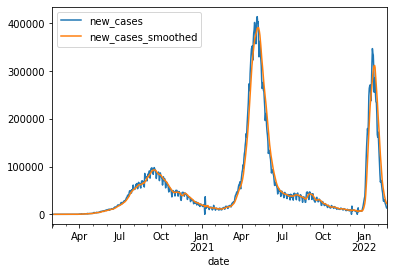

In [9]:
import matplotlib.pyplot as plt
fields = ['new_cases', 'new_cases_smoothed']
c_covid[fields].plot()
plt.show()

### Elimination of missing data


As you can see, there are large fluctuations in the new cases plot. Let's try to make a forecast for these waves.
First of all, we should delete missing data using **pandas.DataFrame.dropna()**


In [10]:
c_covid = c_covid[fields].dropna()
c_covid

,new_cases,new_cases_smoothed
date,,
2020-02-04,0.0,0.429
2020-02-05,0.0,0.429
2020-02-06,0.0,0.286
2020-02-07,0.0,0.286
2020-02-08,0.0,0.286
...,...,...
2022-02-17,25920.0,34871.143
2022-02-18,22270.0,30851.571
2022-02-19,19968.0,27293.143


### Data transformation


 To check for dependencies, it is necessary to perform a correlation analysis between them. This requires:

1.  duplicating of data and moving it vertically down for a certain number of days (lag)
2.  deleting the missing data at the beginning and end **pandas.DataFrame.shift()**
3.  calculating the correlation coefficient between the obtained series.

It is convenient to create a separate function for lag:


In [11]:
def lag_correlation_ts(y, x, lag):
    """
   
    y: fixed
    x: shifted
    lag: lag for shifting
    r: DataFrame of lags correlation coefficients
    """
    r = [0] * (lag + 1)
    y = y.copy()
    x = x.copy()
    y.name = "y"
    x.name = "x"

    for i in range(0, lag + 1):
        ds = y.copy().to_frame()
        ds = ds.join(x.shift(i), how='outer')
        r[i] = ds.corr().values[0][1]
    r = pd.DataFrame(r)
    r.index.names = ['Lag']
    r.columns = ['Correlation']
    return r

Let's create a target DataSet.


In [12]:
y_dataset = c_covid['new_cases']
y_dataset

date
2020-02-04        0.0
2020-02-05        0.0
2020-02-06        0.0
2020-02-07        0.0
2020-02-08        0.0
               ...   
2022-02-17    25920.0
2022-02-18    22270.0
2022-02-19    19968.0
2022-02-20    16051.0
2022-02-21    13405.0
Name: new_cases, Length: 749, dtype: float64

Let's test a 50-day lag.


     Correlation
Lag             
0         1.0000
1         0.9944
2         0.9861
3         0.9773
4         0.9666
5         0.9543
6         0.9417
7         0.9259
8         0.9026
9         0.8770
10        0.8522
11        0.8267
12        0.8004
13        0.7751
14        0.7476
15        0.7148
16        0.6819
17        0.6513
18        0.6213
19        0.5922
20        0.5654
21        0.5379
22        0.5070
23        0.4780
24        0.4523
25        0.4275
26        0.4041
27        0.3835
28        0.3630
29        0.3394
30        0.3181
31        0.2999
32        0.2825
33        0.2664
34        0.2512
35        0.2353
36        0.2162
37        0.1987
38        0.1836
39        0.1689
40        0.1551
41        0.1429
42        0.1298
43        0.1142
44        0.1001
45        0.0874
46        0.0752
47        0.0633
48        0.0529
49        0.0422
50        0.0293


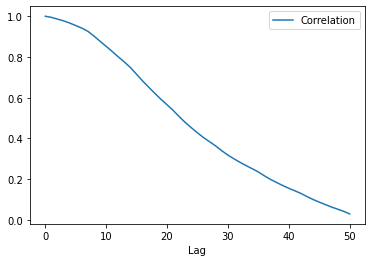

In [13]:
pd.options.display.float_format = '{:,.4f}'.format
l = pd.DataFrame(lag_correlation_ts(y_dataset, y_dataset, 50)) 
print(l)
l.plot()

To automate this process, let's make a universal function for time series transformation to create this DataSet.


In [14]:
def series_to_supervised(in_data, tar_data, n_in=1, dropnan=True, target_dep=False):

    n_vars = in_data.shape[1]
    cols, names = list(), list()

    if target_dep:
        i_start = 1
    else:
        i_start = 0
    for i in range(i_start, n_in + 1):
        cols.append(in_data.shift(i))
        names += [('%s(t-%d)' % (in_data.columns[j], i)) for j in range(n_vars)]

    if target_dep:
        for i in range(n_in, -1, -1):
            cols.append(tar_data.shift(i))
            names += [('%s(t-%d)' % (tar_data.name, i))]
    else:
        # put it all together
        cols.append(tar_data)
        names.append(tar_data.name)
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

 When forecasting time series, the input and output fields are the same, only shifted by the lag.


In [15]:
dataset = series_to_supervised(pd.DataFrame(y_dataset), y_dataset, 14)
dataset

,new_cases(t-0),new_cases(t-1),new_cases(t-2),new_cases(t-3),new_cases(t-4),new_cases(t-5),new_cases(t-6),new_cases(t-7),new_cases(t-8),new_cases(t-9),new_cases(t-10),new_cases(t-11),new_cases(t-12),new_cases(t-13),new_cases(t-14),new_cases
date,,,,,,,,,,,,,,,,
2020-02-18,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-02-19,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-02-20,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-02-21,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-02-22,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,"25,920.0000","30,757.0000","30,615.0000","27,409.0000","34,113.0000","44,877.0000","50,407.0000","58,077.0000","67,084.0000","71,365.0000","67,597.0000","83,876.0000","107,474.0000","127,952.0000","149,394.0000","25,920.0000"
2022-02-18,"22,270.0000","25,920.0000","30,757.0000","30,615.0000","27,409.0000","34,113.0000","44,877.0000","50,407.0000","58,077.0000","67,084.0000","71,365.0000","67,597.0000","83,876.0000","107,474.0000","127,952.0000","22,270.0000"
2022-02-19,"19,968.0000","22,270.0000","25,920.0000","30,757.0000","30,615.0000","27,409.0000","34,113.0000","44,877.0000","50,407.0000","58,077.0000","67,084.0000","71,365.0000","67,597.0000","83,876.0000","107,474.0000","19,968.0000"


As you can see, the first and last columns contain the same target data.
Now we should create input (**X**) and output (**Y**) .


In [16]:
col = dataset.columns
X, Y = dataset[col[1:-1]], dataset[col[-1]]
print("Input: ", X.columns)
print("Target:", Y.name)

Input:  Index(['new_cases(t-1)', 'new_cases(t-2)', 'new_cases(t-3)', 'new_cases(t-4)',
       'new_cases(t-5)', 'new_cases(t-6)', 'new_cases(t-7)', 'new_cases(t-8)',
       'new_cases(t-9)', 'new_cases(t-10)', 'new_cases(t-11)',
       'new_cases(t-12)', 'new_cases(t-13)', 'new_cases(t-14)'],
      dtype='object')
Target: new_cases


### Data normalization


After that, we should normalize all the data. To do this, the **sklearn.preprocessing.MinMaxScaler** module should be used.
It allows us to normalize **fit_transform()** and convert back all the data easily: **inverse_transform()**.


In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaled_x = scaler_x.fit_transform(X)
scaled_y = scaler_y.fit_transform(Y.values.reshape(-1, 1))

After that, we are going to form training and test DataSets using **sklearn.model_selection.train_test_split()**. 

We will make them at the ratio of 73/27. Without shuffling. It means, that test samples are located in the end of **X** and **Y** DataSets.

Input normalized DataSets: **X_train, X_test**

Target normalized DataSets: **y_train, y_test**


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_x, scaled_y, test_size=0.27, shuffle=False)

All the data is normalized now. However, in order to compare to results, we need real scale data of the training and test DataSet:


In [19]:
res_train = scaler_y.inverse_transform(y_train).flatten()
res_test = scaler_y.inverse_transform(y_test).flatten()

Target real scale DataSets: **res_train, res_test**.


# Arima 

In [20]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 8.2 MB/s 
     |████████████████████████████████| 9.8 MB 41.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [21]:

# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from matplotlib import pyplot
# load dataset
auto_arima_model=auto_arima(y_train,trace=True,Supress_warnings=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2797.096, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2747.709, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2757.211, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2758.246, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2749.661, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2754.897, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2764.228, Time=0.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2797.156, Time=1.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2796.938, Time=1.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-2775.796, Time=1.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2882.664, Time=1.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2801.430, Time=1.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-2813.470, Time=2.77 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-2805.493, Time=4.30 sec
 ARIMA(2,1,4)(0,0,0

In [ ]:
arima_model_202 = ARIMA(y_train, order=(3,1,3)).fit()

In [23]:
arima_model_202.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  536
Model:                 ARIMA(3, 1, 3)   Log Likelihood                1451.451
Date:                Tue, 22 Feb 2022   AIC                          -2888.902
Time:                        13:11:31   BIC                          -2858.926
Sample:                             0   HQIC                         -2877.174
                                - 536                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5506      0.019     28.628      0.000       0.513       0.588
ar.L2         -0.5336      0.022    -24.185      0.000      -0.577      -0.490
ar.L3          0.9617      0.018     54.556      0.000       0.927       0.996
ma.L1         -0.4604      0.031    -14.728      0.000      -0.522      -0.399
ma.L2          0.5749      0.038     15.329      0.000       0.501       0.648
ma.L3         -0.7792      0.030    -26.181      0.000      -0.838      -0.721
sigma2         0.0003   7.68e-06     33.414      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):              2004.42
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):              26.07   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
start = dataset.index.get_loc('2020-05-1')
end = dataset.index.get_loc('2022-02-02')
print(start,'to',end)


73 to 715


In [25]:
pred_future_10101=arima_model_202.predict(start=len(dataset)+1,end=len(dataset)+(180),dynamic=False)
print("The length of pred_future values :",len(pred_future_10101))
pred_future_10101

The length of pred_future values : 180


array([0.07099866, 0.07050283, 0.07061752, 0.07093865, 0.0705774 ,
       0.07031745, 0.07067593, 0.07066457, 0.07021704, 0.07032147,
       0.07060683, 0.07027782, 0.07004483, 0.07036656, 0.07035159,
       0.06994761, 0.07004259, 0.07029604, 0.06999638, 0.0697875 ,
       0.07007615, 0.07005834, 0.06969362, 0.06977992, 0.07000492,
       0.06973197, 0.06954465, 0.06980354, 0.06978353, 0.06945422,
       0.06953256, 0.06973217, 0.06948355, 0.06931551, 0.06954762,
       0.06952597, 0.06922859, 0.06929964, 0.06947661, 0.06925014,
       0.06909934, 0.06930737, 0.06928455, 0.06901597, 0.06908033,
       0.06923714, 0.06903082, 0.06889545, 0.06908182, 0.06905824,
       0.06881562, 0.06887386, 0.0690127 , 0.06882474, 0.06870318,
       0.06887007, 0.06884605, 0.06862686, 0.06867951, 0.06880234,
       0.06863108, 0.06852188, 0.06867127, 0.06864709, 0.06844903,
       0.06849656, 0.06860516, 0.0684491 , 0.06835095, 0.06848463,
       0.0684605 , 0.06828151, 0.06832438, 0.0684203 , 0.06827

In [ ]:
history = [x for x in y_train]
predictions = list()
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# walk-forward validation
for t in range(len(y_test)):
	model = ARIMA(history, order=(3,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = y_test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(y_test)
pyplot.plot(predictions, color='red')

pyplot.show()

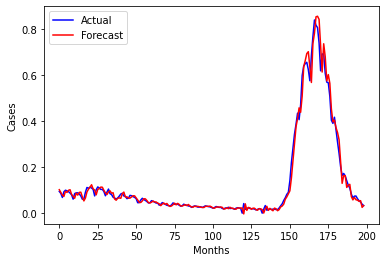

<Figure size 1080x360 with 0 Axes>

In [27]:
pyplot.plot(y_test,color='blue')
pyplot.plot(predictions,color='red')
pyplot.xlabel("Months")
pyplot.ylabel("Cases")
pyplot.legend(['Actual','Forecast'])
fig = plt.figure(figsize=(15, 5))
fig.show()

In [28]:
y_test=y_test.flatten()
y_test

array([0.09432915, 0.08570746, 0.06809468, 0.09259805, 0.09945967,
       0.09686423, 0.09335616, 0.08711744, 0.07952186, 0.06075985,
       0.08493245, 0.08788521, 0.08829565, 0.08319169, 0.07471969,
       0.0605329 , 0.06148657, 0.09076313, 0.11145663, 0.1078206 ,
       0.11289318, 0.10884671, 0.10359788, 0.07470279, 0.10131872,
       0.11369716, 0.10949617, 0.1028953 , 0.10325263, 0.09403459,
       0.07538123, 0.09144398, 0.10445257, 0.0844375 , 0.08058176,
       0.06902904, 0.06580104, 0.06133447, 0.06561272, 0.07380706,
       0.08306132, 0.086101  , 0.07429718, 0.07304895, 0.06305108,
       0.06510087, 0.0770737 , 0.07576753, 0.07150376, 0.06838923,
       0.06287242, 0.04537794, 0.04555902, 0.05680754, 0.06452867,
       0.05879939, 0.05514887, 0.05021633, 0.0442939 , 0.04546969,
       0.05415657, 0.0513221 , 0.04765952, 0.04385931, 0.04377722,
       0.03455677, 0.03820246, 0.0458415 , 0.04071098, 0.03858393,
       0.03415357, 0.03282567, 0.03152675, 0.03530522, 0.04455

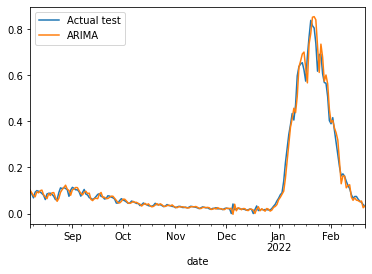

In [29]:
df_2 = pd.DataFrame({'Actual test': y_test, 'ARIMA': predictions,})
df_2.index = dataset.index[len(dataset)-len(res_test):]
df_2.plot()

# Linear Regression


First of all, we should create a model. We will test three type of models. A Linear regression, a Multilayer Neural Network with Backpropagation and a Long Short-Term Memory Neural Network.
Let's create a **LinearRegression()**


In [30]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

After that, our model should be fitted on the training DataSet. Regardless of the model type, the function fit() is used to do this.


In [31]:
regressor.fit(X_train, y_train)

LinearRegression()

Then we can test it on the test DataSet and use it for prognostication.


In [32]:
y_pred_test_ln = regressor.predict(X_test)
y_pred_test_ln = scaler_y.inverse_transform(y_pred_test_ln).flatten()

Let's analyze the results accuracy using **sklearn.metrics**.


In [33]:
from sklearn import metrics
print("Correlation train", regressor.score(X_train, y_train))
print("Correlation test", regressor.score(X_test, y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test_ln))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test_ln))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_ln)))

Correlation train 0.996740968293578
Correlation test 0.9871862114931163
Mean Absolute Error: 55108.251054022854
Mean Squared Error: 9782265593.759396
Root Mean Squared Error: 98905.33652821467


# Back Propagation NN


The modern approach to the establishment of complex functional dependencies is the use of neural networks. A classical neural network is a **multilayer neural network with back propagation**.

To do this, we will use the **keras** framework.
First of all, we should create a Neural Network model as a separate function.

A neural network is a sequence of layers. The function **Sequential()** is used to create a network.

Let's create a network that consists of 2 hidden layers. Each of which consists of 100 neurons. **keras.layers.Dense()**.

To avoid retraining problems, we will use additional layers **keras.layers.Dropout()**.

The output layer will consist of one neuron, since we have only one value at the output.

The model should be compiled for fitting and predicting: **keras.Model.compile()**.


In [34]:
def BP_model(X):
    """
    Multilayer neural network with back propagation.
    X: Input DataSet
    return: keras NN model
    """
    # create model
    model = Sequential() 
    model.add(Dense(100, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Once the model function is built, it is necessary to create a neural network directly and specify the learning parameters: **keras.wrappers.scikit_learn.KerasRegressor()**. 

Also we should define the number of fitting **epoch and batch size**.


In [35]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
epochs = 1000

batch_size=int(y_train.shape[0]*.1)

estimator = KerasRegressor(build_fn=BP_model, X=X_train, epochs=epochs, batch_size=batch_size, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if __name__ == '__main__':


Now, let’s train our model for **1000** epochs.
It should be noted that the fitting process is very slow. Therefore, we saved our fitted model to a file.
To save time, we will upload the fitted model.
If you like, you can leave the parameter **fitting on True** to refit the model.
If you like, you can leave the parameter **fitting_save on True** to resave the model.


In [36]:
fitting = True
fitting_save = True

import pickle

if fitting:
    history=estimator.fit(X_train,y_train, validation_data=(X_test,y_test)) # Fitting model
    if fitting_save:
        # Save model
        estimator.model.save('BP_saved_model.h5')
        print("Saved model to disk")
        with open('history.pickle', 'wb') as f:
            pickle.dump(history.history, f)
# load model 
from keras.models import load_model
estimator = KerasRegressor(build_fn=BP_model, X=X_train, epochs=epochs, batch_size=batch_size, verbose=1)
estimator.model = load_model('BP_saved_model.h5')    
with open('history.pickle', 'rb') as f:
    history = pickle.load(f)
print("Loaded model from disk")

Epoch 1/1000
11/11 [==============================] - 1s 19ms/step - loss: 0.0411 - val_loss: 0.0210
Epoch 2/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.0176
Epoch 3/1000
11/11 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0105
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0095
Epoch 5/1000
11/11 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0085
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0074
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0071
Epoch 8/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 9/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0052
Epoch 10/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.004

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  app.launch_new_instance()


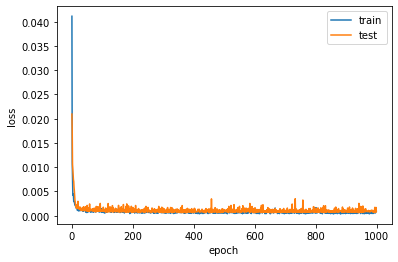

In [37]:
plt.figure()
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

As you can see, a Neural Network is well-fitted and no overfitting is observed.
Let's calculate a prediction of the training (**res_train_ANN**) an test (**res_test_ANN**) sets.


Let's calculate a forecast and make an inverse normalization to real scale.


In [38]:
res_tr=estimator.predict(X_train)
res_ts=estimator.predict(X_test)
res_train_ANN=scaler_y.inverse_transform(res_tr.reshape(-1, 1)).flatten()
res_test_ANN=scaler_y.inverse_transform(res_ts.reshape(-1, 1)).flatten()

4/4 [==============================] - 0s 3ms/step


Let's compare the accuracy of a Linear Regression and a Neural Network.


In [39]:
print("Correlation train", np.corrcoef(res_train, res_train_ANN)[0,1])
print("Correlation train", np.corrcoef(res_test, res_test_ANN)[0,1])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, res_test_ANN))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, res_test_ANN))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, res_test_ANN)))

Correlation train 0.9971613243040638
Correlation train 0.9899442530100304
Mean Absolute Error: 52893.75095230404
Mean Squared Error: 8596762394.619236
Root Mean Squared Error: 92718.72731341407


We got slightly better results for a Neural Network than for a Linear Regression.


# Long Short-Term Memory - LSTM


Unlike standard feedforward neural networks, **LSTM** has feedback connections. It can process not only single data points, but also entire sequences of data (such as speech, video or time series).

In case of time series, the neural network has one input and one output. However, there should be a vector of time series values for the previous time period on the input.


To do this, we should transform input DataSets into 3D shape.


In [40]:
train_x_LSTM = X_train.reshape((X_train.shape[0], 1, 14))
test_x_LSTM = X_test.reshape((X_test.shape[0], 1, 14))

Let's create an LSTM Neural Network consisting of one **LSTM** layer and one BP layer like in the previous case.
In this case our NN will consist of 7 LSTM and 7 BP neurons only.


In [41]:
from keras.layers import LSTM

batch_size=int(y_train.shape[0]*.1)
model = Sequential()
model.add(LSTM(7, input_shape=(train_x_LSTM.shape[1], train_x_LSTM.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(7, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1])) #activation='sigmoid'
model.compile(loss='mean_squared_error', optimizer='adam')



All subsequent steps of learning, storing, reading and predicting are similar to the ones we used with the previous neural network. You can see that only 420 epochs are enough for an LSTM.


In [42]:
fitting = True
fitting_save = True
epochs = 420

if fitting:
    history = model.fit(train_x_LSTM, y_train, epochs=epochs, batch_size=batch_size, validation_data=(test_x_LSTM, y_test), verbose=1, shuffle=False)    
    if fitting_save:
    # serialize model to JSON
        model_json = model.to_json()
        with open("LSTM_model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("LSTM_model.h5")
        print("Saved model to disk")
        with open('history_LSTM.pickle', 'wb') as f:
            pickle.dump(history.history, f)
# load model  
from keras.models import model_from_json
json_file = open('LSTM_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("LSTM_model.h5")        
with open('history_LSTM.pickle', 'rb') as f: 
    history = pickle.load(f)
print("Loaded model from disk")

Epoch 1/420
11/11 [==============================] - 3s 55ms/step - loss: 0.0593 - val_loss: 0.0512
Epoch 2/420
11/11 [==============================] - 0s 4ms/step - loss: 0.0553 - val_loss: 0.0482
Epoch 3/420
11/11 [==============================] - 0s 6ms/step - loss: 0.0525 - val_loss: 0.0457
Epoch 4/420
11/11 [==============================] - 0s 6ms/step - loss: 0.0491 - val_loss: 0.0434
Epoch 5/420
11/11 [==============================] - 0s 6ms/step - loss: 0.0468 - val_loss: 0.0414
Epoch 6/420
11/11 [==============================] - 0s 5ms/step - loss: 0.0449 - val_loss: 0.0396
Epoch 7/420
11/11 [==============================] - 0s 5ms/step - loss: 0.0433 - val_loss: 0.0381
Epoch 8/420
11/11 [==============================] - 0s 5ms/step - loss: 0.0420 - val_loss: 0.0367
Epoch 9/420
11/11 [==============================] - 0s 4ms/step - loss: 0.0397 - val_loss: 0.0355
Epoch 10/420
11/11 [==============================] - 0s 5ms/step - loss: 0.0375 - val_loss: 0.0343
Epoch 11

Let's plot the dynamic of loss and val loss like in the previous case.


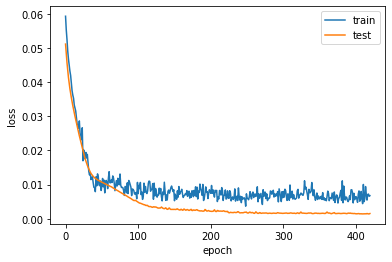

In [43]:
plt.figure()
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend()
plt.show()

Let's calculate our forecast.


In [44]:
res_tr_LSTM = model.predict(train_x_LSTM)
res_ts_LSTM = model.predict(test_x_LSTM)
res_train_LSTM=scaler_y.inverse_transform(res_tr_LSTM).flatten()
res_test_LSTM=scaler_y.inverse_transform(res_ts_LSTM).flatten()

And accuracy:


In [45]:
print("Correlation train", np.corrcoef(res_train, res_train_LSTM)[0,1])
print("Correlation train", np.corrcoef(res_test, res_test_LSTM)[0,1])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, res_test_LSTM))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, res_test_LSTM))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, res_test_LSTM)))

Correlation train 0.9961142425614169
Correlation train 0.9818295321862508
Mean Absolute Error: 57052.92923630216
Mean Squared Error: 8739259304.287827
Root Mean Squared Error: 93484.00560677654


In [46]:
res_test

array([ 39070.,  35499.,  28204.,  38353.,  41195.,  40120.,  38667.,
        36083.,  32937.,  25166.,  35178.,  36401.,  36571.,  34457.,
        30948.,  25072.,  25467.,  37593.,  46164.,  44658.,  46759.,
        45083.,  42909.,  30941.,  41965.,  47092.,  45352.,  42618.,
        42766.,  38948.,  31222.,  37875.,  43263.,  34973.,  33376.,
        28591.,  27254.,  25404.,  27176.,  30570.,  34403.,  35662.,
        30773.,  30256.,  26115.,  26964.,  31923.,  31382.,  29616.,
        28326.,  26041.,  18795.,  18870.,  23529.,  26727.,  24354.,
        22842.,  20799.,  18346.,  18833.,  22431.,  21257.,  19740.,
        18166.,  18132.,  14313.,  15823.,  18987.,  16862.,  15981.,
        14146.,  13596.,  13058.,  14623.,  18454.,  15786.,  16326.,
        15906.,  14306.,  12428.,  13451.,  16156.,  14348.,  14313.,
        12830.,  12514.,  10423.,  11903.,  12885.,  12729.,  10929.,
        10826.,  11478.,  10126.,  11466.,  13091.,  12516.,  11850.,
        11271.,  102

As you can see, the forecast results of the test data set are much better than ones of the previous models. Let's visualize these 3 results:


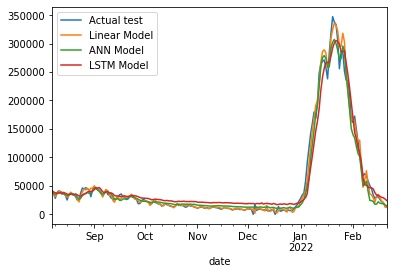

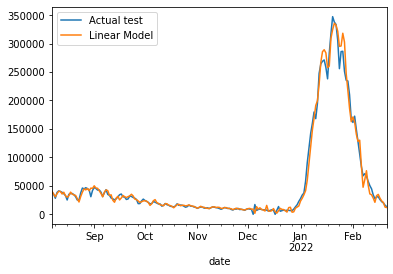

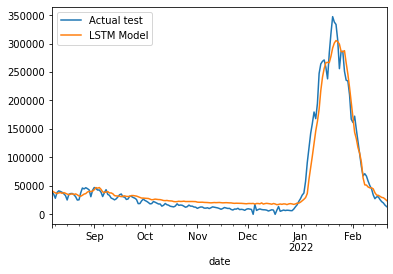

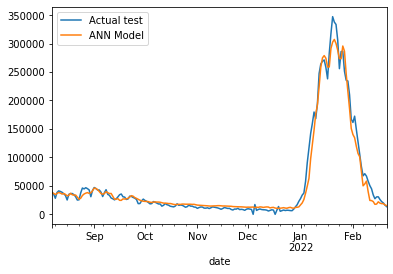

In [47]:
res_pred_test_ln = pd.Series(y_pred_test_ln, name = 'Predicted test Linear Model')
res_pred_test_ANN = pd.Series(res_test_ANN, name = 'Predicted test ANN')
res_pred_test_LSTM = pd.Series(res_test_LSTM, name = 'Predicted test LSTM')

df_2 = pd.DataFrame({'Actual test': res_test, 'Linear Model': res_pred_test_ln, 'ANN Model': res_pred_test_ANN,  'LSTM Model': res_pred_test_LSTM,})
df_2.index = dataset.index[len(dataset)-len(res_test):]
df_2.plot()
df_2 = pd.DataFrame({'Actual test': res_test, 'Linear Model': res_pred_test_ln,})
df_2.index = dataset.index[len(dataset)-len(res_test):]
df_2.plot()
df_2 = pd.DataFrame({'Actual test': res_test, 'LSTM Model': res_pred_test_LSTM,})
df_2.index = dataset.index[len(dataset)-len(res_test):]
df_2.plot()
df_2 = pd.DataFrame({'Actual test': res_test,'ANN Model': res_pred_test_ANN,})
df_2.index = dataset.index[len(dataset)-len(res_test):]
df_2.plot()
plt.show()